In [5]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer
from processes import RRXORProcess

# The Random-Random-XOR Process

In [6]:
# Testing the modified function
sample_data, sample_positions = RRXORProcess.generate(10, with_positions=True)
sample_data, sample_positions



(['1', '0', '1', '0', '1', '1', '1', '0', '0', '0'],
 ['R2', 'XOR', 'R1', 'R2', 'XOR', 'R1', 'R2', 'XOR', 'R1', 'R2'])

## Example data

In [7]:
''.join([str(x) for x in RRXORProcess.generate(1000)])

'101100111101011010000000110111011101010000000000110111100001101010110001010001010001101101011011011101010001010111100110110111101011010110110110001011011011011101100110111011011100111101011010111011100111010111010110000001100001010001011011010000111101101010110000111100000001011101010110110001101011101010111100110111011101101010110110110001010110111100001101100000000111100110111010000110000110111011010000001100110110110001010001101011010111010111101100110001100110110001101010000000001100001010000111101100000111010000111010111011011010000001101010111101100111101011011100111010001101010000110111011011011101011100000001101100111011011100111100000110110000001101100000001011101100000110001010000000000000001101101010001100110000110000000001010001100111100001011011011100001101100000110000110000111010110111101100001010001101011010111101100001011101011010111010111011011100110110001011100111100000001100111101011101101011011101101100111100001010111011100001010001010000000110001100110111011101101

In [8]:
# Define a config for the transformer
config = {
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 20,  # context length
    'd_head': 16,
    'n_head': 1,
    'd_mlp': 4*16,
    'n_layers': 1
}

batch_size = 32
sequence_length = 10000
num_epochs = 100

# Generate sequence data with positions
sequence, sequence_positions = RRXORProcess.generate(sequence_length, with_positions=True)
train_inputs, train_targets, test_inputs, test_targets = RRXORProcess.create_train_test_data(sequence, config['input_size'])
train_loader = RRXORProcess.create_data_loader(train_inputs, train_targets, batch_size)
test_loader = RRXORProcess.create_data_loader(test_inputs, test_targets, batch_size)


NameError: name 'torch' is not defined

In [5]:
# print a few examples from the training data
for i in range(5):
    print('X:', train_inputs[i])
    print('Y:', train_targets[i])
    print()

X: tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0])
Y: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

X: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])
Y: tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1])

X: tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1])
Y: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0])

X: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0])
Y: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

X: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])
Y: tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0])



In [33]:
import torch.nn as nn
import torch.optim as optim

# 3. Model Definition

model = MultilayerTransformer(**config)

# print if cuda is available
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    model = model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

def compute_accuracy(predictions, targets):
    """
    Compute accuracy for predictions against targets.
    """
    correct_preds = (predictions == targets).float()
    accuracy = correct_preds.mean().item()
    return accuracy


CUDA Available: True


In [31]:
# Print the table header
print("\nTraining Results:")
print("-" * 80)
header = "| Epoch | Training Acc | Training Loss | Overall Test Acc | Last Bit Test Acc |"
print(header)
print("-" * 80)

# Adjusted training loop with tabulated printing and accuracy reporting on the test set at the end of each epoch

for epoch in range(num_epochs):
    # Training
    model.train()  # set the model to training mode

    running_acc = 0.0
    num_batches = 0

    for batch_inputs, batch_targets in zip(train_input_batches, train_target_batches):
        if torch.cuda.is_available():
            batch_inputs, batch_targets = batch_inputs.cuda(), batch_targets.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(batch_inputs)
        loss = criterion(outputs.view(-1, config['d_vocab']), batch_targets.view(-1))
        loss.backward()
        
        
        scheduler.step(loss)

        # Keep track of accuracy and number of batches
        running_acc += compute_accuracy(torch.argmax(outputs, dim=-1)[:,-1], batch_targets[:,-1])
        num_batches += 1
    
    # Calculate training results after each epoch
    avg_training_acc = running_acc / num_batches
    
    # Evaluation on test set after each epoch
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():  # no gradients needed for evaluation
        overall_accuracies = []
        last_bit_accuracies = []

        # Iterate over test batches
        for idx, (batch_inputs, batch_targets) in enumerate(zip(test_input_batches, test_target_batches)):
            if torch.cuda.is_available():
                batch_inputs, batch_targets = batch_inputs.cuda(), batch_targets.cuda()

            # Get model predictions
            outputs = model(batch_inputs)
            predicted_classes = torch.argmax(outputs, dim=-1)

            # Compute overall accuracy
            overall_accuracy = compute_accuracy(predicted_classes, batch_targets)
            overall_accuracies.append(overall_accuracy)

            # Compute accuracy for the last bit
            last_bit_accuracy = compute_accuracy(predicted_classes[:, -1], batch_targets[:, -1])
            last_bit_accuracies.append(last_bit_accuracy)

        # Calculate average accuracies for the entire test set after each epoch
        avg_overall_accuracy = sum(overall_accuracies) / len(overall_accuracies)
        avg_last_bit_accuracy = sum(last_bit_accuracies) / len(last_bit_accuracies)

    optimizer.step(avg_overall_accuracy)

    

    # Print the results in a tabulated format
    row = f"| {epoch+1:^5} | {avg_training_acc:^12.2%} | {loss.item():^13.4f} | {avg_overall_accuracy:^17.2%} | {avg_last_bit_accuracy:^16.2%} |"
    print(row)

print("-" * 80)



Training Results:
--------------------------------------------------------------------------------
| Epoch | Training Acc | Training Loss | Overall Test Acc | Last Bit Test Acc |
--------------------------------------------------------------------------------
Epoch 00045: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00056: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00067: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00078: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00089: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00100: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00111: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00122: reducing learning rate of group 0 to 3.9063e-06.
Epoch 00133: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00144: reducing learning rate of group 0 to 9.7656e-07.
Epoch 00155: reducing learning rate of group 0 to 4.8828e-07.
Epoch 00166: reducing learning rate of group 0 to 2.4414e

KeyboardInterrupt: 

In [113]:
train_inputs.shape

torch.Size([7992, 9])

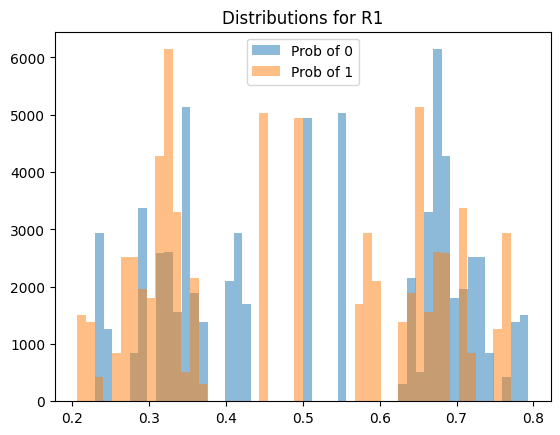

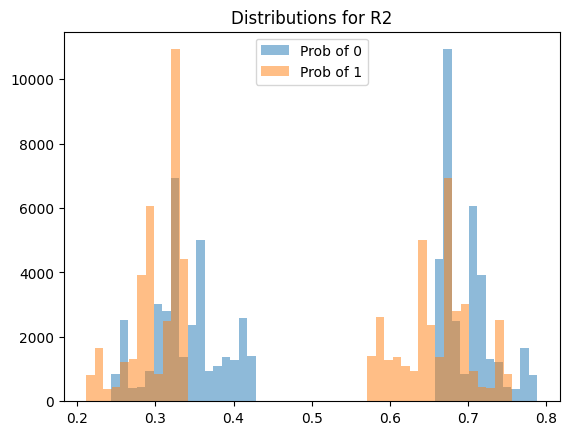

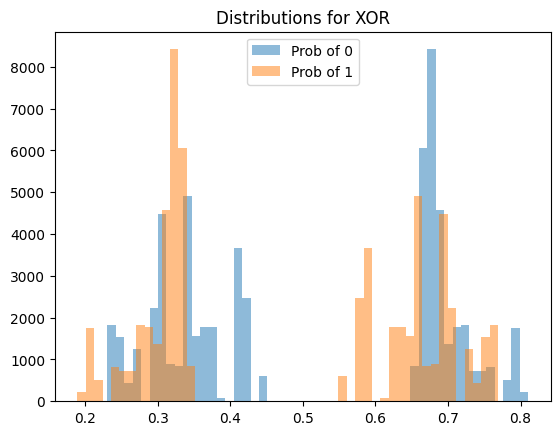

In [8]:
import numpy as np

# First, let's convert the sequence into tensor format for model evaluation
sequence_tensor = torch.tensor([[int(bit) for bit in sequence[i:i+config['input_size']]] 
                                for i in range(len(sequence) - config['input_size'] + 1)], dtype=torch.long)

if torch.cuda.is_available():
    sequence_tensor = sequence_tensor.cuda()

# Evaluate the model on the sequence
model.eval()
with torch.no_grad():
    sequence_outputs = model(sequence_tensor)
    sequence_probs = torch.nn.functional.softmax(sequence_outputs, dim=-1).cpu().numpy()

# Initialize lists to store probabilities for each position type
probs_R1 = []
probs_R2 = []
probs_XOR = []

# Loop over each position in the context window and group by position type
for position in range(config['input_size']):
    # Determine position type from sequence_position
    position_type = sequence_positions[position]
    
    if position_type == "R1":
        probs_R1.extend(sequence_probs[:, position, :])
    elif position_type == "R2":
        probs_R2.extend(sequence_probs[:, position, :])
    else:
        probs_XOR.extend(sequence_probs[:, position, :])

# Convert lists to numpy arrays for easier handling
probs_R1 = np.array(probs_R1)
probs_R2 = np.array(probs_R2)
probs_XOR = np.array(probs_XOR)

# Now, we'll plot the distributions
import matplotlib.pyplot as plt

# Helper function to plot histograms for a given position type and its probabilities
def plot_histogram(probs, position_type):
    plt.hist(probs[:, 0], bins=50, alpha=0.5, label='Prob of 0')
    plt.hist(probs[:, 1], bins=50, alpha=0.5, label='Prob of 1')
    plt.title(f'Distributions for {position_type}')
    plt.legend()
    plt.show()

plot_histogram(probs_R1, "R1")
plot_histogram(probs_R2, "R2")
plot_histogram(probs_XOR, "XOR")


In [9]:
# Modified plotting code to handle each position type separately

def plot_probs_by_position(positions, probs, label):
    """Helper function to plot probabilities for a given position type."""
    plt.plot(positions, probs, label=label, marker='o')

# Determine positions for each type
positions_R1 = [i for i, pos in enumerate(sequence_positions) if pos == "R1"]
positions_R2 = [i for i, pos in enumerate(sequence_positions) if pos == "R2"]
positions_XOR_1 = [i for i, pos in enumerate(sequence_positions) if pos == "XOR" and true_values[i][-1] == 1]
positions_XOR_0 = [i for i, pos in enumerate(sequence_positions) if pos == "XOR" and true_values[i][-1] == 0]

# Plot the results
plot_probs_by_position(positions_R1, avg_probs_R1, 'R1')
plot_probs_by_position(positions_R2, avg_probs_R2, 'R2')
plot_probs_by_position(positions_XOR_1, avg_probs_XOR_1, 'XOR (True=1)')
plot_probs_by_position(positions_XOR_0, avg_probs_XOR_0, 'XOR (True=0)')

plt.xlabel('Position in Context Window')
plt.ylabel('P(1)')
plt.legend()
plt.title('Predicted Probabilities for Each Context Position')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


NameError: name 'true_values' is not defined

In [10]:
# Lists to store average probabilities for each context window position
probs_by_context_position = {i: [] for i in range(config['input_size'])}

# Populate the probabilities by context window position
for context_position in range(config['input_size']):
    position_type = sequence_positions[context_position]
    if position_type == "XOR":
        # Differentiate based on true value
        mask = np.array(true_values)[:, context_position] == 1
        label_1 = f"Position_{context_position}_XOR_True1"
        label_0 = f"Position_{context_position}_XOR_True0"
        if label_1 not in probs_by_context_position:
            probs_by_context_position[label_1] = []
            probs_by_context_position[label_0] = []
        probs_by_context_position[label_1].extend(sequence_probs[mask, context_position, 1])
        probs_by_context_position[label_0].extend(sequence_probs[~mask, context_position, 1])
    else:
        label = f"Position_{context_position}_{position_type}"
        if label not in probs_by_context_position:
            probs_by_context_position[label] = []
        probs_by_context_position[label].extend(sequence_probs[:, context_position, 1])

# Plot the results
for label, probs in probs_by_context_position.items():
    plt.hist(probs, bins=50, label=label, alpha=0.6)

plt.xlabel('P(1)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Predicted Probabilities by Context Window Position')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


NameError: name 'true_values' is not defined

In [11]:
# Compute the average probabilities for each context window position
avg_probs_by_context_position = {label: np.mean(probs) for label, probs in probs_by_context_position.items()}

# Split the labels to extract position and type for sorting
positions = [int(label.split("_")[1]) for label in avg_probs_by_context_position.keys()]
labels = [label.split("_")[2:] for label in avg_probs_by_context_position.keys()]

# Sort by position
sorted_indices = np.argsort(positions)
sorted_labels = [f"{'_'.join(labels[i])}" for i in sorted_indices]
sorted_avg_probs = [avg_probs_by_context_position[f"Position_{positions[i]}_{'_'.join(labels[i])}"] for i in sorted_indices]

# Plot the results
plt.bar(sorted_labels, sorted_avg_probs, alpha=0.6)

plt.xlabel('Context Window Position')
plt.ylabel('Mean P(1)')
plt.title('Mean Predicted Probabilities by Context Window Position')
plt.xticks(rotation=45, ha="right")
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


AttributeError: 'int' object has no attribute 'split'

In [12]:
# 1. Convert the sequence into tensor format for model evaluation
sequence_tensor = torch.tensor([[int(bit) for bit in sequence[i:i+config['input_size']]]
                                for i in range(len(sequence) - config['input_size'] + 1)], dtype=torch.long)

if torch.cuda.is_available():
    sequence_tensor = sequence_tensor.cuda()

# 2. Evaluate the model on the sequence
model.eval()
with torch.no_grad():
    sequence_outputs = model(sequence_tensor)
    sequence_probs = torch.nn.functional.softmax(sequence_outputs, dim=-1).cpu().numpy()

# 3. Group the probabilities by their context window position and true values

# Initial empty lists for each context window position
avg_probs_by_context_position = {f"Position_{i}": [] for i in range(config['input_size'])}

# Populate the probabilities by context window position
for context_position in range(config['input_size']):
    position_type = sequence_positions[context_position]
    if position_type == "XOR":
        # Differentiate based on true value
        mask = np.array(true_values)[:, context_position] == 1
        label_1 = f"Position_{context_position}_XOR_True1"
        label_0 = f"Position_{context_position}_XOR_True0"
        avg_probs_by_context_position[label_1] = np.mean(sequence_probs[mask, context_position, 1])
        avg_probs_by_context_position[label_0] = np.mean(sequence_probs[~mask, context_position, 1])
    else:
        label = f"Position_{context_position}_{position_type}"
        avg_probs_by_context_position[label] = np.mean(sequence_probs[:, context_position, 1])

# 5. Plot the results

positions = list(avg_probs_by_context_position.keys())
avg_probs = list(avg_probs_by_context_position.values())

plt.bar(positions, avg_probs, alpha=0.6)

plt.xlabel('Context Window Position')
plt.ylabel('Mean P(1)')
plt.title('Mean Predicted Probabilities by Context Window Position')
plt.xticks(rotation=45, ha="right")
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


NameError: name 'true_values' is not defined

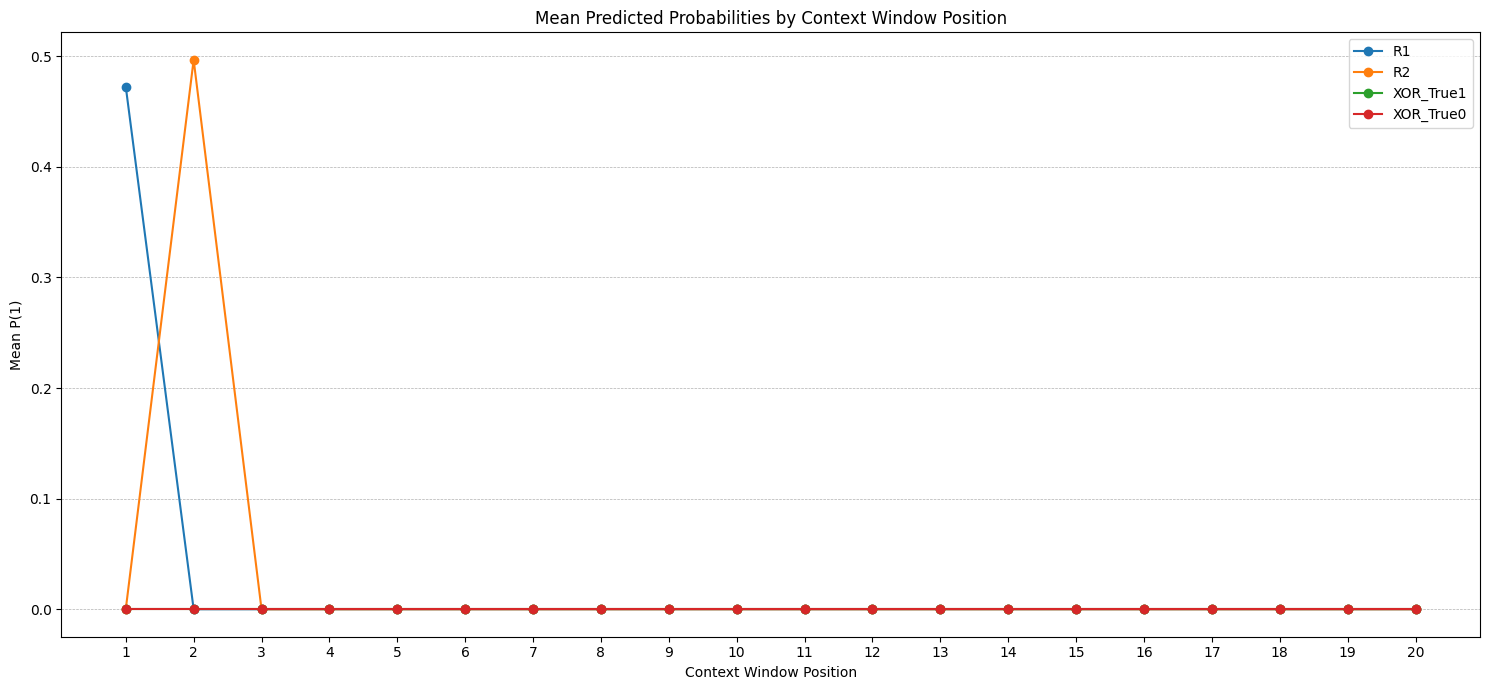

In [13]:
# Extract the mean P(1) for each position and type

# Initialize dictionary to hold the results
results_by_type = {
    "R1": [],
    "R2": [],
    "XOR_True1": [],
    "XOR_True0": []
}

# Extract the values based on position and type
for context_position in range(config['input_size']):
    for label_type in results_by_type.keys():
        label = f"Position_{context_position}_{label_type}"
        results_by_type[label_type].append(avg_probs_by_context_position.get(label, 0.0))

# Plot the results

plt.figure(figsize=(15, 7))

# Plot each type
for label_type, values in results_by_type.items():
    plt.plot(values, label=label_type, marker='o')

plt.xlabel('Context Window Position')
plt.ylabel('Mean P(1)')
plt.title('Mean Predicted Probabilities by Context Window Position')
plt.xticks(range(config['input_size']), range(1, config['input_size'] + 1))
plt.legend(loc='upper right')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# 1. Convert the sequence into tensor format for model evaluation
sequence_tensor = torch.tensor([[int(bit) for bit in sequence[i:i+config['input_size']]]
                                for i in range(len(sequence) - config['input_size'] + 1)], dtype=torch.long)

if torch.cuda.is_available():
    sequence_tensor = sequence_tensor.cuda()

# 2. Evaluate the model on the sequence
model.eval()
with torch.no_grad():
    sequence_outputs = model(sequence_tensor)
    sequence_probs = torch.nn.functional.softmax(sequence_outputs, dim=-1).cpu().numpy()

# 3. Prepare the data for analysis using pandas

data = []

for i, probs in enumerate(sequence_probs):
    shifted_types = sequence_positions[i:i+config['input_size']]
    for j, prob in enumerate(probs):
        
        data.append({
            'Context_Window_Position': j + 1,
            'Type': shifted_types[j],
            'True_Value': sequence[i + j],
            'Predicted_Prob_1': prob[1],
            'Predicted_Prob_0': prob[0],
            'Actual Prediction': np.argmax(prob)
        })

df = pd.DataFrame(data)

df.head()


,Context_Window_Position,Type,True_Value,Predicted_Prob_1,Predicted_Prob_0,Actual Prediction
0,1,R1,0,0.490945,0.509055,0
1,2,R2,0,0.323566,0.676434,0
2,3,XOR,0,0.327406,0.672594,0
3,4,R1,1,0.719785,0.280215,1
4,5,R2,1,0.335994,0.664006,0


In [15]:
accuracy = (df['True_Value'] == df['Actual Prediction']).mean()
print(f"Overall Accuracy: {accuracy:.2%}")

Overall Accuracy: 0.00%


In [16]:
accuracy = (df['True_Value'].astype('int') == df['Actual Prediction'].astype('int')).astype('int')
accuracy.mean()

0.4955715860134255

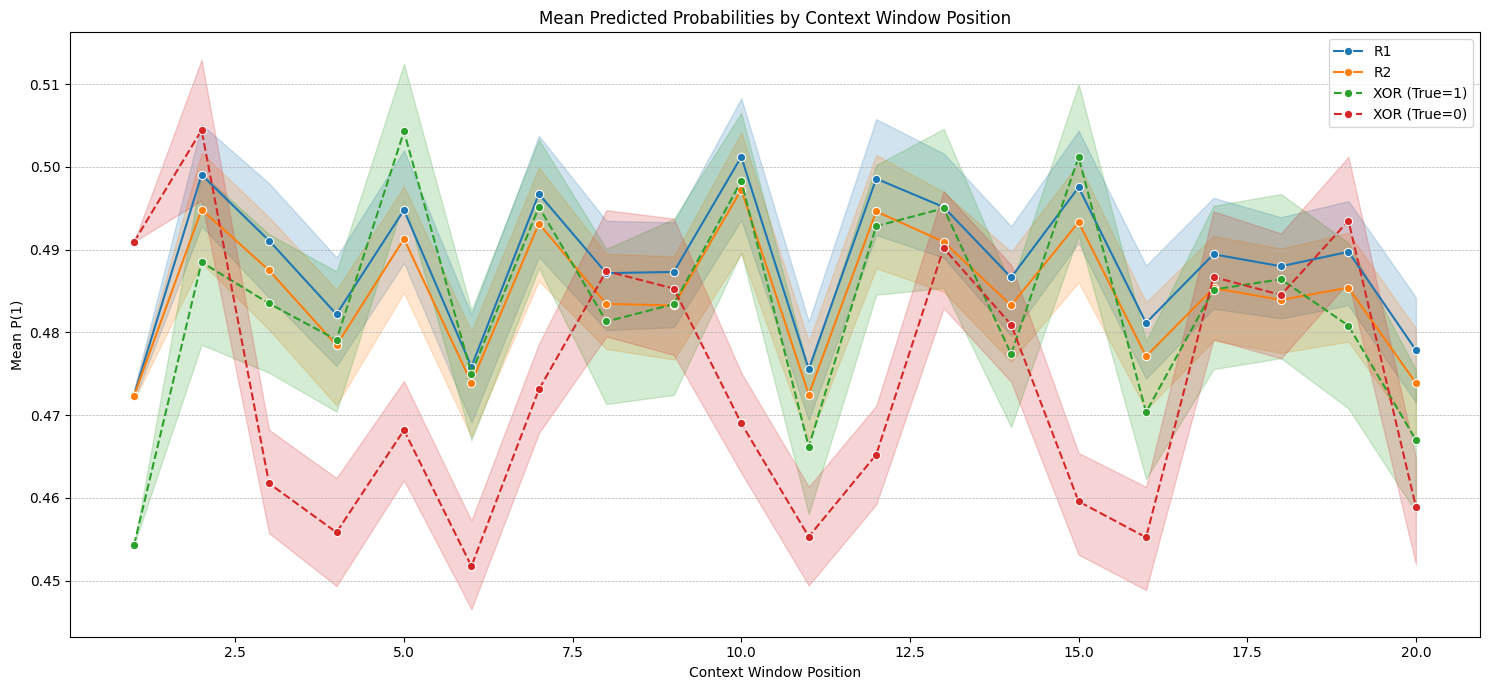

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for XOR true value
df_XOR_1 = df[(df['Type'] == 'XOR') & (df['True_Value'] == '1')]
df_XOR_0 = df[(df['Type'] == 'XOR') & (df['True_Value'] == '0')]
df_R1 = df[df['Type'] == 'R1']
df_R2 = df[df['Type'] == 'R2']

plt.figure(figsize=(15, 7))

# Plot each type
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_R1, label='R1', marker='o')
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_R2, label='R2', marker='o')
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_XOR_1, label='XOR (True=1)', marker='o', linestyle='--')
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_XOR_0, label='XOR (True=0)', marker='o', linestyle='--')

plt.xlabel('Context Window Position')
plt.ylabel('Mean P(1)')
plt.title('Mean Predicted Probabilities by Context Window Position')
plt.legend(loc='upper right')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [18]:
# Print header for post-training analysis
print("\nPost-training Analysis:")
print("-" * 80)
header_analysis = "| Context Window Position | R1 Mean P(1) | R2 Mean P(1) | XOR(0) Mean P(1) | XOR(1) Mean P(1) |"
print(header_analysis)
print("-" * 80)

# Convert the entire sequence into tensor format for model evaluation
sequence_tensor = torch.tensor([[int(bit) for bit in sequence[i:i+config['input_size']]]
                                for i in range(len(sequence) - config['input_size'] + 1)], dtype=torch.long)

if torch.cuda.is_available():
    sequence_tensor = sequence_tensor.cuda()

# Evaluate the model on the sequence
model.eval()
with torch.no_grad():
    sequence_outputs = model(sequence_tensor)
    sequence_probs = torch.nn.functional.softmax(sequence_outputs, dim=-1).cpu().numpy()

# Organize predictions by context window position and sequence position (R1, R2, XOR)
data = []
for i, probs in enumerate(sequence_probs):
    shifted_positions = sequence_positions[i:i+config['input_size']]
    for j, prob in enumerate(probs):
        data.append({
            'Context_Window_Position': j + 1,
            'Type': shifted_positions[j],
            'Predicted_Prob_1': prob[1]
        })

df = pd.DataFrame(data)

# Calculate mean P(1) values for each context window position and sequence type
for position in range(1, config['input_size'] + 1):
    r1_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R1')]['Predicted_Prob_1'].mean()
    r2_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R2')]['Predicted_Prob_1'].mean()
    xor0_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_0')]['Predicted_Prob_1'].mean()
    xor1_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_1')]['Predicted_Prob_1'].mean()

    row_analysis = f"| {position:^24} | {r1_mean_prob:^12.2%} | {r2_mean_prob:^12.2%} | {xor0_mean_prob:^16.2%} | {xor1_mean_prob:^16.2%} |"
    print(row_analysis)

print("-" * 80)



Post-training Analysis:
--------------------------------------------------------------------------------
| Context Window Position | R1 Mean P(1) | R2 Mean P(1) | XOR(0) Mean P(1) | XOR(1) Mean P(1) |
--------------------------------------------------------------------------------
|            1             |    47.25%    |    47.24%    |       nan%       |       nan%       |
|            2             |    49.90%    |    49.48%    |       nan%       |       nan%       |
|            3             |    49.11%    |    48.75%    |       nan%       |       nan%       |
|            4             |    48.22%    |    47.84%    |       nan%       |       nan%       |
|            5             |    49.48%    |    49.13%    |       nan%       |       nan%       |
|            6             |    47.58%    |    47.39%    |       nan%       |       nan%       |
|            7             |    49.67%    |    49.31%    |       nan%       |       nan%       |
|            8             |    48.72%

In [19]:
def create_batches_with_positions(data, positions, batch_size):
    """Create batches from the data along with the sequence positions."""
    return ([data[i:i+batch_size] for i in range(0, len(data), batch_size)],
            [positions[i:i+batch_size] for i in range(0, len(data), batch_size)])

# Create batches for training and test data along with their positions
train_input_batches, train_position_batches = create_batches_with_positions(train_inputs, sequence_positions[:split_idx], batch_size)
test_input_batches, test_position_batches = create_batches_with_positions(test_inputs, sequence_positions[split_idx:len(test_inputs)+split_idx], batch_size)

# Print the table header
print("\nTraining Results:")
print("-" * 80)
header = "| Epoch | Training Acc | Training Loss | Overall Test Acc | Last Bit Test Acc |"
print(header)
print("-" * 80)

# Adjusted training loop with tabulated printing and accuracy reporting on the test set at the end of each epoch

for epoch in range(2):
    # Training
    model.train()  # set the model to training mode

    running_acc = 0.0
    num_batches = 0

    for batch_inputs, batch_targets in zip(train_input_batches, train_target_batches):
        if torch.cuda.is_available():
            batch_inputs, batch_targets = batch_inputs.cuda(), batch_targets.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(batch_inputs)
        loss = criterion(outputs.view(-1, config['d_vocab']), batch_targets.view(-1))
        loss.backward()
        optimizer.step()

        # Keep track of accuracy and number of batches
        running_acc += compute_accuracy(torch.argmax(outputs, dim=-1)[:,-1], batch_targets[:,-1])
        num_batches += 1
    
    # Calculate training results after each epoch
    avg_training_acc = running_acc / num_batches
    
    # Evaluation on test set after each epoch
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():  # no gradients needed for evaluation
        overall_accuracies = []
        last_bit_accuracies = []

        # Iterate over test batches
        for idx, (batch_inputs, batch_targets) in enumerate(zip(test_input_batches, test_target_batches)):
            if torch.cuda.is_available():
                batch_inputs, batch_targets = batch_inputs.cuda(), batch_targets.cuda()

            # Get model predictions
            outputs = model(batch_inputs)
            predicted_classes = torch.argmax(outputs, dim=-1)

            # Compute overall accuracy
            overall_accuracy = compute_accuracy(predicted_classes, batch_targets)
            overall_accuracies.append(overall_accuracy)

            # Compute accuracy for the last bit
            last_bit_accuracy = compute_accuracy(predicted_classes[:, -1], batch_targets[:, -1])
            last_bit_accuracies.append(last_bit_accuracy)

        # Calculate average accuracies for the entire test set after each epoch
        avg_overall_accuracy = sum(overall_accuracies) / len(overall_accuracies)
        avg_last_bit_accuracy = sum(last_bit_accuracies) / len(last_bit_accuracies)

    # Print the results in a tabulated format
    row = f"| {epoch+1:^5} | {avg_training_acc:^12.2%} | {loss.item():^13.4f} | {avg_overall_accuracy:^17.2%} | {avg_last_bit_accuracy:^16.2%} |"
    print(row)

print("-" * 80)

# Print header for post-training analysis
print("\nPost-training Analysis:")
print("-" * 80)
header_analysis = "| Context Window Position | R1 Mean P(1) | R2 Mean P(1) | XOR(0) Mean P(1) | XOR(1) Mean P(1) |"
print(header_analysis)
print("-" * 80)
# Organize predictions by context window position and sequence position (R1, R2, XOR)
data = []

model.eval()
with torch.no_grad():
    for idx, (batch_inputs, batch_positions) in enumerate(zip(test_input_batches, test_position_batches)):
        if torch.cuda.is_available():
            batch_inputs = batch_inputs.cuda()
        
        # Evaluate the model on the test batch
        batch_outputs = model(batch_inputs)
        batch_probs = torch.nn.functional.softmax(batch_outputs, dim=-1).cpu().numpy()

        # Store the results
        for i, probs in enumerate(batch_probs):
            for j, prob in enumerate(probs):
                true_value = batch_inputs[i, j].item()
                data.append({
                    'Context_Window_Position': j + 1,
                    'Type': batch_positions[i],
                    'True_Value': true_value,
                    'Predicted_Prob_1': prob[1],
                    'Predicted_Class': 1 if prob[1] > 0.5 else 0
                })

df = pd.DataFrame(data)

# Calculate mean P(1) values and accuracy for each context window position and sequence type
print("\nPost-training Analysis:")
print("-" * 115)
header_analysis = "| Context Win. Pos. | R1 Mean P(1) | R2 Mean P(1) | XOR(0) Mean P(1) | XOR(1) Mean P(1) | R1 Acc. | R2 Acc. | XOR(0) Acc. | XOR(1) Acc. |"
print(header_analysis)
print("-" * 115)

for position in range(1, config['input_size'] + 1):
    r1_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R1')]['Predicted_Prob_1'].mean()
    r2_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R2')]['Predicted_Prob_1'].mean()
    xor0_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_0')]['Predicted_Prob_1'].mean()
    xor1_mean_prob = df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_1')]['Predicted_Prob_1'].mean()

    r1_acc = (df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R1')]['Predicted_Class'] == df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R1')]['True_Value']).mean()
    r2_acc = (df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R2')]['Predicted_Class'] == df[(df['Context_Window_Position'] == position) & (df['Type'] == 'R2')]['True_Value']).mean()
    xor0_acc = (df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_0')]['Predicted_Class'] == df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_0')]['True_Value']).mean()
    xor1_acc = (df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_1')]['Predicted_Class'] == df[(df['Context_Window_Position'] == position) & (df['Type'] == 'XOR_1')]['True_Value']).mean()

    row_analysis = f"| {position:^16} | {r1_mean_prob:^12.2%} | {r2_mean_prob:^12.2%} | {xor0_mean_prob:^16.2%} | {xor1_mean_prob:^16.2%} | {r1_acc:^7.2%} | {r2_acc:^7.2%} | {xor0_acc:^11.2%} | {xor1_acc:^11.2%} |"
    print(row_analysis)

print("-" * 115)

# compute overall accuracy
overall_accuracy = (df['True_Value'] == df['Predicted_Class']).mean()
print(f"Overall Accuracy: {overall_accuracy:.2%}")



Training Results:
--------------------------------------------------------------------------------
| Epoch | Training Acc | Training Loss | Overall Test Acc | Last Bit Test Acc |
--------------------------------------------------------------------------------
|   1   |    66.66%    |    0.6498     |      64.57%       |      65.16%      |
|   2   |    66.66%    |    0.6494     |      64.57%       |      65.16%      |
--------------------------------------------------------------------------------

Post-training Analysis:
--------------------------------------------------------------------------------
| Context Window Position | R1 Mean P(1) | R2 Mean P(1) | XOR(0) Mean P(1) | XOR(1) Mean P(1) |
--------------------------------------------------------------------------------

Post-training Analysis:
-------------------------------------------------------------------------------------------------------------------
| Context Win. Pos. | R1 Mean P(1) | R2 Mean P(1) | XOR(0) Mean P(1) | XOR

In [20]:
df

,Context_Window_Position,Type,True_Value,Predicted_Prob_1,Predicted_Class
0,1,R2,1,0.531863,1
1,2,R2,0,0.672326,1
2,3,R2,1,0.663403,1
3,4,R2,1,0.361063,0
4,5,R2,0,0.633565,1
...,...,...,...,...,...
39915,16,R2,1,0.410872,0
39916,17,R2,0,0.657227,1
39917,18,R2,0,0.359001,0
39918,19,R2,1,0.670341,1


In [21]:
# compute overall accuracy
overall_accuracy = (df['True_Value'] == df['Predicted_Class']).mean()
print(f"Overall Accuracy: {overall_accuracy:.2%}")

Overall Accuracy: 48.18%


In [22]:
# After the data split
print(f"Length of test data during training loop: {len(test_inputs)}")

# After the post-training analysis data collection
print(f"Length of test data in post-training analysis: {len(df)}")


Length of test data during training loop: 1996
Length of test data in post-training analysis: 39920


In [23]:
last_bit_accuracy = (df[df['Context_Window_Position'] == config['input_size']]['True_Value'] == df[df['Context_Window_Position'] == config['input_size']]['Predicted_Class']).mean()
print(f"Last Bit Accuracy: {last_bit_accuracy:.2%}")


Last Bit Accuracy: 47.95%


C:\Users\adamimos\AppData\Local\Temp\ipykernel_38756\2290197349.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Context_Window_Position', y='Predicted_Prob_1', hue='Type', ci=None, marker="o")


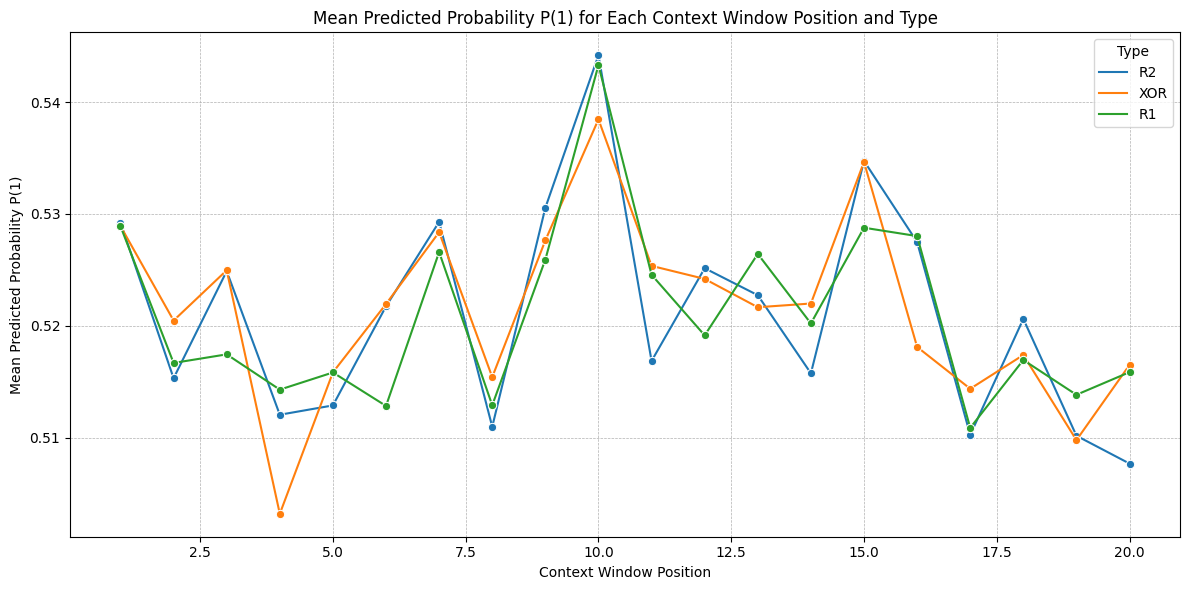

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Context_Window_Position', y='Predicted_Prob_1', hue='Type', ci=None, marker="o")

plt.title('Mean Predicted Probability P(1) for Each Context Window Position and Type')
plt.ylabel('Mean Predicted Probability P(1)')
plt.xlabel('Context Window Position')
plt.legend(title='Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


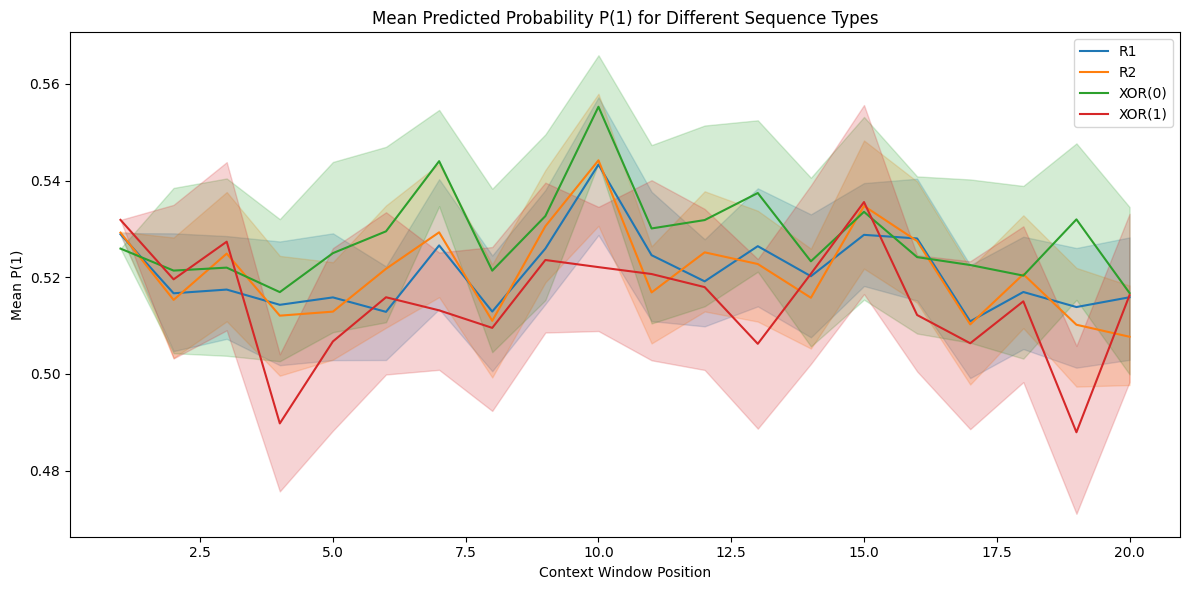

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out data for each type
df_r1 = df[df['Type'] == 'R1']
df_r2 = df[df['Type'] == 'R2']
df_xor0 = df[(df['Type'] == 'XOR') & (df['True_Value'] == 0)]
df_xor1 = df[(df['Type'] == 'XOR') & (df['True_Value'] == 1)]

plt.figure(figsize=(12, 6))

# Plot each type
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_r1, label='R1')
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_r2, label='R2')
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_xor0, label='XOR(0)')
sns.lineplot(x='Context_Window_Position', y='Predicted_Prob_1', data=df_xor1, label='XOR(1)')

plt.legend()
plt.title('Mean Predicted Probability P(1) for Different Sequence Types')
plt.xlabel('Context Window Position')
plt.ylabel('Mean P(1)')
plt.tight_layout()
plt.show()


In [26]:
# accuracy of xor0 at position 6
accuracy = (df[(df['Context_Window_Position'] == 6) & (df['Type'] == 'XOR') & (df['True_Value'] == 0)]['True_Value'] == df[(df['Context_Window_Position'] == 6) & (df['Type'] == 'XOR') & (df['True_Value'] == 0)]['Predicted_Class']).mean()